## Goal

The goal of this notebook is two-fold:

*   Introduction to the Transfer Learning
*   Gain experience with three dimensional input data (colored images), and pretrained models (Part-A)

## Dataset
[**CelebA**](https://www.cs.toronto.edu/~kriz/cifar.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Reserve 10% of the training data for validation and %10 for test** and  **use the rest for development (learning your models). The test data (3000 samples) should only be used for testing at the end, and not model selection.**

## Task
Build a classifier with the PyTorch library function calls and pretrained models to *classify gender* in the CelebA dataset, completing the given code and without changing the network.


## Software:

Pytorch is a library that we will use especially for deep learning, but also with basic neural network functionality of course.

You may find the necessary function references here:

https://pytorch.org/

https://pytorch.org/vision/stable/index.html

https://pytorch.org/docs/stable/torch.html

https://pytorch.org/docs/stable/nn.html

## 2) Load training dataset




In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from numpy import random
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import os


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
np.random.seed(5)

%matplotlib inline

In [ ]:
IMG_SIZE = (128,128)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/courses/spring2023/CS 515 - Deep Learning/HW-2/celeba_30k.csv')
data.head()

,image_id,Male,Blond_Hair,Eyeglasses,Wearing_Earrings,Bangs,Young,Smiling,Heavy_Makeup,Straight_Hair,Black_Hair
0,000001.jpg,0,0,0,1,0,1,1,1,1,0
1,000002.jpg,0,0,0,0,0,1,1,0,0,0
2,000003.jpg,1,0,0,0,0,1,0,0,0,0
3,000004.jpg,0,0,0,1,0,1,0,0,1,0
4,000005.jpg,0,0,0,0,0,1,0,1,0,0


In [ ]:
gender_data = data[['image_id', 'Male']].copy()
gender_data.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
#this will extract the contents of the zip file into a folder named data
#do not extract the zip into your google drive (i.e don't use drive/My Drive in the right path since it slows down the process)
#only change the left path

!unzip "/content/drive/MyDrive/courses/spring2023/CS 515 - Deep Learning/HW-2/celeba_30k.zip" -d "/content/data"

In [ ]:
first_image_path = os.path.join("/content/data/celeba_30k/", gender_data.loc[0,"image_id"])
img = Image.open(first_image_path)

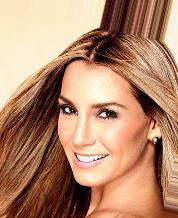

In [ ]:
img

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as its memory usage, distribution of labels, etc.


### basic approach for visualizing

Female 013379.jpg


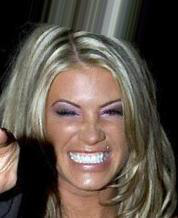

******************************
Female 023188.jpg


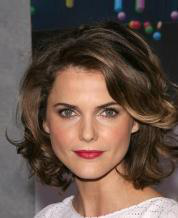

******************************
Female 009258.jpg


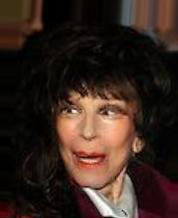

******************************
Male 027924.jpg


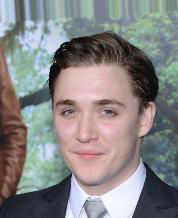

******************************
Female 010293.jpg


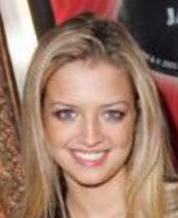

******************************


In [ ]:
# plot random 5 images in your dataset with their labels
root = "/content/data/celeba_30k/"
for i in range(5):
    image = os.listdir(root)[random.randint(0, len(os.listdir(root)))]
    label = gender_data["Male"][gender_data.index[gender_data.image_id == image].to_list()[0]]
    img = Image.open(os.path.join(root, image))
    label_str = "Male" if label == 1 else "Female"
    print(label_str, image)
    img.show()
    print("*"*30)

### with custom dataset class

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

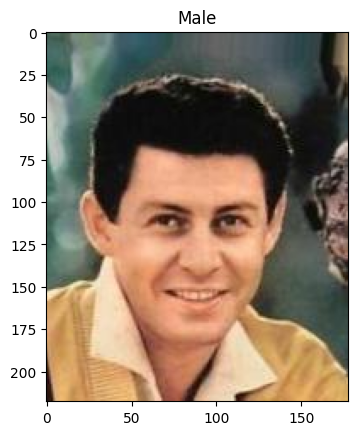

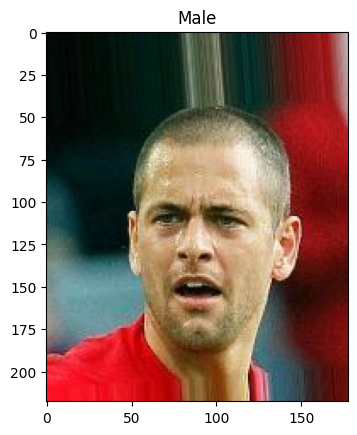

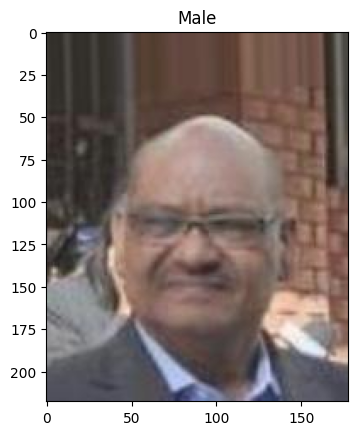

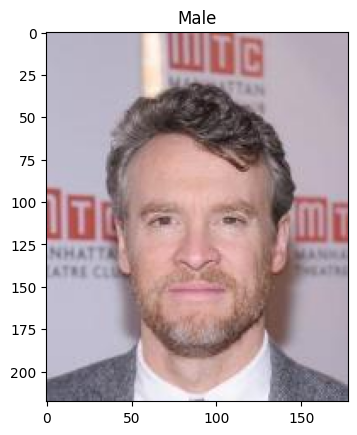

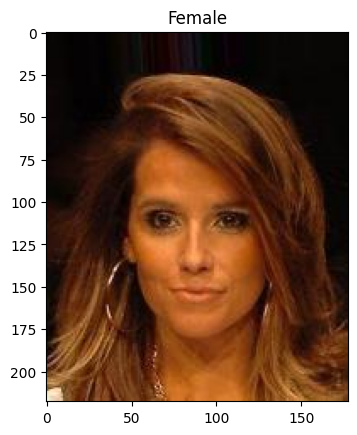

In [ ]:
dataset = ImageDataset(gender_data, "/content/data/celeba_30k/")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

features, labels = next(iter(data_loader))
for i in range(len(features)):
    img = features[i]
    label = "Male" if labels[i] else "Female"
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.title(label)
    plt.show()

### dataset statistics

In [ ]:
gender_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  30000 non-null  object
 1   Male      30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


In [ ]:
gender_data["Male"].value_counts()

0    17320
1    12680
Name: Male, dtype: int64

##4) Split the dataset as train (also called development) (80%) and validation (10%) and test (10%) set. You'll tune the hyperparameters using the validation set and evaulate the model on the unseen test set.

In [ ]:
# Split 80-10-10
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(gender_data, test_size=0.1, random_state=42, shuffle = True)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=42, shuffle = True) #since 0.9 * (1/9) = 0.1

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image

class CelebADataset(nn.Module):
    def __init__(self, root_dir, img_pths, labels, is_train):
        self.root_dir = root_dir
        self.img_pths = img_pths
        self.labels = labels
        if not is_train:
            self.transform = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(0.3, 0.3, 0.3, 0.3),
                transforms.RandomGrayscale(),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

    def __len__(self):
        return len(self.img_pths)

    def __getitem__(self, idx):
        img_pth = os.path.join(self.root_dir, self.img_pths[idx])
        image = Image.open(img_pth)
        label = self.labels[idx]
        label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        sample = {"img": image, "label": label}
        return sample


# Prepare Datasets

root_dir = "/content/data/celeba_30k/"

train_img_pths = np.array(train_df["image_id"])
train_img_labels = np.array(train_df["Male"])

val_img_pths = np.array(val_df["image_id"])
val_img_labels = np.array(val_df["Male"])

test_img_pths = np.array(test_df["image_id"])
test_img_labels = np.array(test_df["Male"])

train_dataset = CelebADataset(root_dir, train_img_pths, train_img_labels, True)
val_dataset = CelebADataset(root_dir, val_img_pths, val_img_labels, False)
test_dataset = CelebADataset(root_dir, test_img_pths, test_img_labels, False)

In [ ]:
train_dataset[0]

{'img': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-1.8097, -1.8097, -1.8097,  ...,  1.6324,  1.6324,  1.6324],
          [-1.7925, -1.7925, -1.7925,  ...,  1.6324,  1.6324,  1.6324],
          [-1.7583, -1.7583, -1.7583,  ...,  1.6324,  1.6324,  1.6324]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-1.8256, -1.8431, -1.8431,  ...,  1.7983,  1.7983,  1.7983],
          [-1.8256, -1.8256, -1.8256,  ...,  1.7108,  1.7108,  1.7108],
          [-1.8081, -1.8081, -1.8081,  ...,  1.6758,  1.6758,  1.6758]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -

##5) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 model. This is pre-trained on ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes.

First, you need to pick which layer of VGG-16 you will use for feature extraction, which is the features section.

By setting the requires_grad to False, we ensure that the original (ImageNet) weights of the model will remain constant.

Note that it is possible to adjust the number of trainable layers by modifying the for loop.


In [ ]:
import torchvision.models as models

class VGG16_Updated(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_Updated, self).__init__()
        self.featurizer = models.vgg16(pretrained=True).features

        for n, p in self.featurizer.named_parameters():
            p.requires_grad = False

        self.clf = torch.nn.Linear(4*4*512, num_classes) # 4*4*512 is the shape of the final feature map in vgg16 arch.

    def forward(self, x):
        B, C, H, W = x.shape
        feats = self.featurizer(x)
        feats = torch.flatten(feats, 1) # flatten
        out = self.clf(feats)
        return out

We need a binary classifier (Male/Female) which we will add manually on top of the pre-trained model. This layer is usually called "classification head".


In [ ]:
def train_one_epoch(train_dataloader, opt):
    model.train()
    accs = []
    losses = []
    start = time.time()
    for i, sample in enumerate(train_dataloader):
        imgs = sample["img"]
        labels = sample["label"]
        # send data to device
        imgs = imgs.cuda()
        labels = labels.cuda()

        logits = model(imgs) # take predictions
        loss = F.cross_entropy(logits, labels) # calculate loss

        preds = torch.argmax(logits, dim=1) # convert predictions into labels
        correct = torch.sum(torch.eq(preds.int(), labels.int()).float()) # count # of correct preds

        clf_accuracy = correct / imgs.shape[0] # calculate accuracy

        accs.append(clf_accuracy.cpu())
        losses.append(loss.item())
        # take a step to optimize model params
        opt.zero_grad()
        loss.backward()
        opt.step()

    time_elapsed = time.time() - start
    acc = np.mean(accs)
    loss = np.mean(losses)
    return {"acc": acc, "loss": loss, "time": time_elapsed}


def test_val_one_epoch(dataloader):
    model.eval()
    accs = []
    losses = []
    start = time.time()
    with torch.no_grad():
        for i, sample in enumerate(dataloader):
            imgs = sample["img"]
            labels = sample["label"]
            # send data to device
            imgs = imgs.cuda()
            labels = labels.cuda()

            logits = model(imgs) # take predictions
            loss = F.cross_entropy(logits, labels) # calculate loss

            preds = torch.argmax(logits, dim=1) # convert predictions into labels
            correct = torch.sum(torch.eq(preds.int(), labels.int()).float()) # calculate # of correct preds

            clf_accuracy = correct / imgs.shape[0] # calculate accuracy
            accs.append(clf_accuracy.cpu())
            losses.append(loss.item())
    time_elapsed = time.time() - start
    acc = np.mean(accs)
    loss = np.mean(losses)
    return {"acc": acc, "loss": loss, "time": time_elapsed}


## 6-) Fine-Tuning the Model

Since our base model is trained on a different dataset (ImageNet), we still need to tune the hyperparameters.
Tune learning rate (most important), optimizer (which one to use?).

You can also experiment with other hyperparameters i.e
- Batch size
- Learning rate decay depending on your optimizer

### Tuning optimizers (Adam vs SGD)

#### common params

In [ ]:
from torch.utils.data import DataLoader
import time

batch_size = 128

lr = 1e-5 # choose a learning rate

num_epochs = 3 # choose number of epochs
eval_every = 1 # evaluation on every epoch

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
tuning_results = []

#### Adam

In [ ]:
# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: epoch: 1, loss: 0.58, accuracy: 69.24 in 138.04 seconds
Validation: epoch: 1, loss: 0.40, accuracy: 83.56 in 10.16 seconds
Training: epoch: 2, loss: 0.38, accuracy: 84.93 in 136.85 seconds
Validation: epoch: 2, loss: 0.31, accuracy: 88.01 in 10.11 seconds
Training: epoch: 3, loss: 0.32, accuracy: 87.65 in 133.61 seconds
Validation: epoch: 3, loss: 0.28, accuracy: 89.16 in 10.05 seconds


#### SGD

In [ ]:
# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.SGD(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "sgd", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

Training: epoch: 1, loss: 0.59, accuracy: 69.64 in 133.97 seconds
Validation: epoch: 1, loss: 0.47, accuracy: 81.51 in 10.26 seconds
Training: epoch: 2, loss: 0.48, accuracy: 79.31 in 133.78 seconds
Validation: epoch: 2, loss: 0.40, accuracy: 84.77 in 9.46 seconds
Training: epoch: 3, loss: 0.43, accuracy: 82.61 in 134.87 seconds
Validation: epoch: 3, loss: 0.36, accuracy: 86.09 in 10.16 seconds


#### Final Result for Optimizers

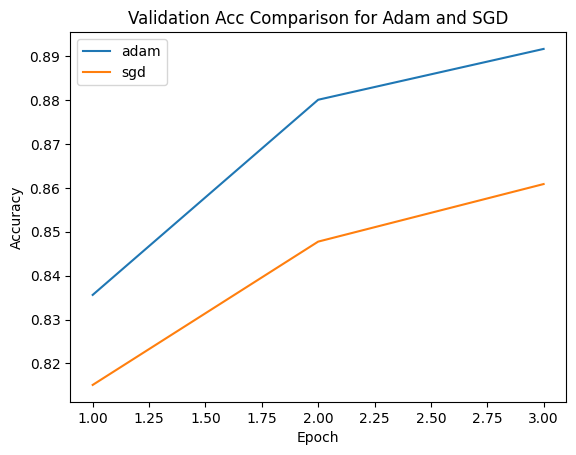

In [ ]:
for item in range(len(tuning_results)):
    plt.plot(range(1,4), [epoch["acc"] for epoch in tuning_results[item]["val_info"]], label=tuning_results[item]["optimizer"])
plt.legend()
plt.title("Validation Acc Comparison for Adam and SGD")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

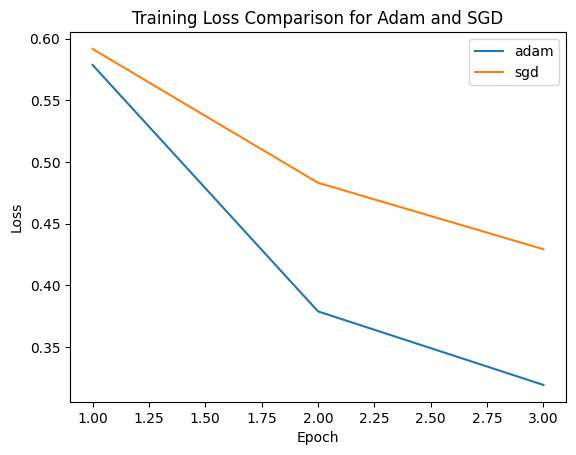

In [ ]:
for item in range(len(tuning_results)):
    plt.plot(range(1,4), [epoch["loss"] for epoch in tuning_results[item]["train_info"]], label=tuning_results[item]["optimizer"])
plt.legend()
plt.title("Training Loss Comparison for Adam and SGD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Tuning Learning Rate

In [ ]:
num_epochs = 5

tuning_results = []

#### LR = 1e-5

In [ ]:
lr = 1e-5 # choose a learning rate

# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: epoch: 1, loss: 0.51, accuracy: 76.64 in 152.76 seconds
Validation: epoch: 1, loss: 0.37, accuracy: 85.10 in 9.98 seconds
Training: epoch: 2, loss: 0.35, accuracy: 86.89 in 131.89 seconds
Validation: epoch: 2, loss: 0.30, accuracy: 88.43 in 10.10 seconds
Training: epoch: 3, loss: 0.30, accuracy: 88.66 in 133.09 seconds
Validation: epoch: 3, loss: 0.27, accuracy: 89.16 in 9.65 seconds
Training: epoch: 4, loss: 0.28, accuracy: 89.21 in 132.88 seconds
Validation: epoch: 4, loss: 0.25, accuracy: 89.89 in 10.07 seconds
Training: epoch: 5, loss: 0.26, accuracy: 89.62 in 133.71 seconds
Validation: epoch: 5, loss: 0.24, accuracy: 90.09 in 9.37 seconds


#### LR = 1e-4

In [ ]:
lr = 1e-4 # choose a learning rate

# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

Training: epoch: 1, loss: 0.29, accuracy: 87.62 in 133.33 seconds
Validation: epoch: 1, loss: 0.24, accuracy: 89.42 in 10.14 seconds
Training: epoch: 2, loss: 0.22, accuracy: 91.30 in 133.64 seconds
Validation: epoch: 2, loss: 0.21, accuracy: 91.29 in 9.82 seconds
Training: epoch: 3, loss: 0.21, accuracy: 91.87 in 133.76 seconds
Validation: epoch: 3, loss: 0.20, accuracy: 91.75 in 10.24 seconds
Training: epoch: 4, loss: 0.20, accuracy: 92.36 in 133.61 seconds
Validation: epoch: 4, loss: 0.19, accuracy: 92.17 in 9.91 seconds
Training: epoch: 5, loss: 0.19, accuracy: 92.74 in 132.46 seconds
Validation: epoch: 5, loss: 0.19, accuracy: 92.13 in 9.95 seconds


#### LR = 1e-3

In [ ]:
lr = 1e-3 # choose a learning rate

# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

Training: epoch: 1, loss: 0.25, accuracy: 90.10 in 132.55 seconds
Validation: epoch: 1, loss: 0.21, accuracy: 91.92 in 10.00 seconds
Training: epoch: 2, loss: 0.22, accuracy: 91.70 in 133.65 seconds
Validation: epoch: 2, loss: 0.24, accuracy: 90.63 in 9.87 seconds
Training: epoch: 3, loss: 0.21, accuracy: 91.95 in 133.15 seconds
Validation: epoch: 3, loss: 0.24, accuracy: 91.94 in 9.76 seconds
Training: epoch: 4, loss: 0.20, accuracy: 92.59 in 135.33 seconds
Validation: epoch: 4, loss: 0.22, accuracy: 91.88 in 9.65 seconds
Training: epoch: 5, loss: 0.20, accuracy: 92.77 in 138.52 seconds
Validation: epoch: 5, loss: 0.22, accuracy: 91.83 in 10.21 seconds


#### Final Result for Learning Rate

In [ ]:
len(tuning_results)

5

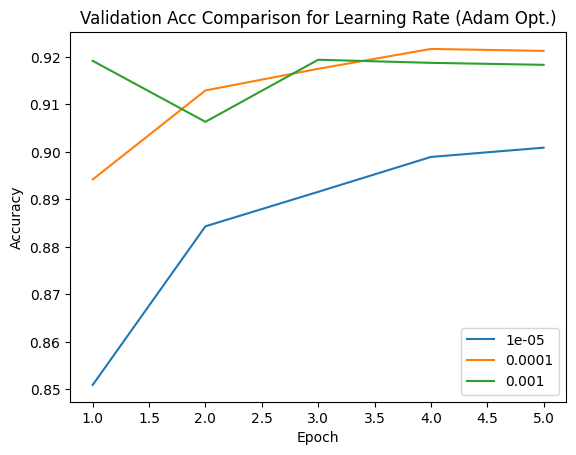

In [ ]:
for item in range(len(tuning_results)):
    plt.plot(range(1,6), [epoch["acc"] for epoch in tuning_results[item]["val_info"]], label=tuning_results[item]["lr"])
plt.legend()
plt.title("Validation Acc Comparison for Learning Rate (Adam Opt.)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

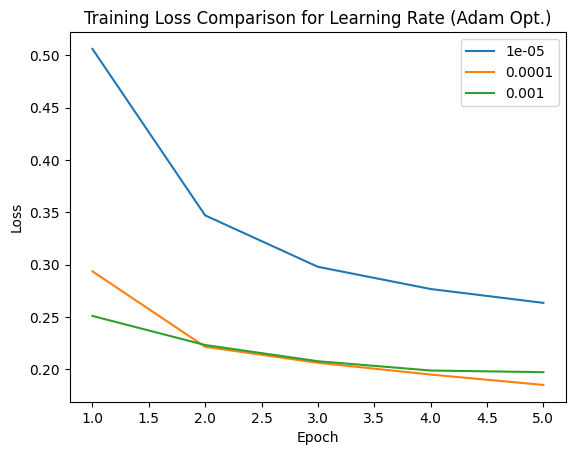

In [ ]:
for item in range(tuning_results):
    plt.plot(range(1,6), [epoch["loss"] for epoch in tuning_results[item]["train_info"]], label=tuning_results[item]["lr"])
plt.legend()
plt.title("Training Loss Comparison for Learning Rate (Adam Opt.)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

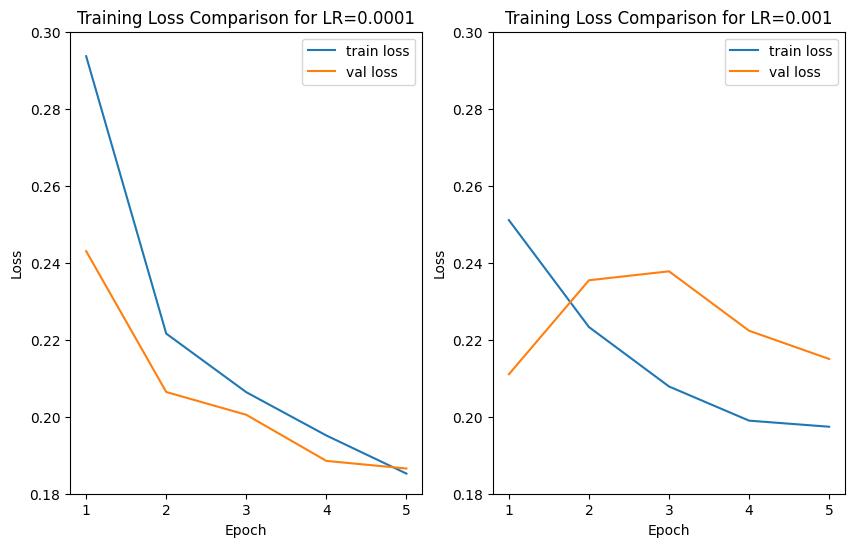

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.ylim(0.18, 0.30)
plt.plot(range(1,6), [epoch["loss"] for epoch in tuning_results[1]["train_info"]], label="train loss")
plt.plot(range(1,6), [epoch["loss"] for epoch in tuning_results[1]["val_info"]], label="val loss")
plt.legend()
plt.title("Training Loss Comparison for LR="+ str(tuning_results[1]["lr"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2) # row 1, col 2 index 1
plt.ylim(0.18, 0.30)
plt.plot(range(1,6), [epoch["loss"] for epoch in tuning_results[2]["train_info"]], label="train loss")
plt.plot(range(1,6), [epoch["loss"] for epoch in tuning_results[2]["val_info"]], label="val loss")
plt.legend()
plt.title("Training Loss Comparison for LR="+ str(tuning_results[2]["lr"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Tuning Epochs

In [ ]:
num_epochs = 10

In [ ]:
lr = 1e-4 # choose a learning rate

# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training: epoch: 1, loss: 0.32, accuracy: 86.06 in 163.15 seconds
Validation: epoch: 1, loss: 0.23, accuracy: 90.52 in 9.64 seconds
Training: epoch: 2, loss: 0.23, accuracy: 91.04 in 136.13 seconds
Validation: epoch: 2, loss: 0.21, accuracy: 90.90 in 10.32 seconds
Training: epoch: 3, loss: 0.21, accuracy: 91.67 in 135.54 seconds
Validation: epoch: 3, loss: 0.20, accuracy: 91.39 in 9.95 seconds
Training: epoch: 4, loss: 0.20, accuracy: 92.22 in 133.47 seconds
Validation: epoch: 4, loss: 0.19, accuracy: 91.54 in 10.15 seconds
Training: epoch: 5, loss: 0.19, accuracy: 92.48 in 134.49 seconds
Validation: epoch: 5, loss: 0.20, accuracy: 91.28 in 10.21 seconds
Training: epoch: 6, loss: 0.19, accuracy: 92.87 in 133.53 seconds
Validation: epoch: 6, loss: 0.19, accuracy: 92.17 in 10.09 seconds
Training: epoch: 7, loss: 0.18, accuracy: 92.81 in 133.43 seconds
Validation: epoch: 7, loss: 0.18, accuracy: 92.59 in 10.11 seconds
Training: epoch: 8, loss: 0.18, accuracy: 93.04 in 132.51 seconds
Valid

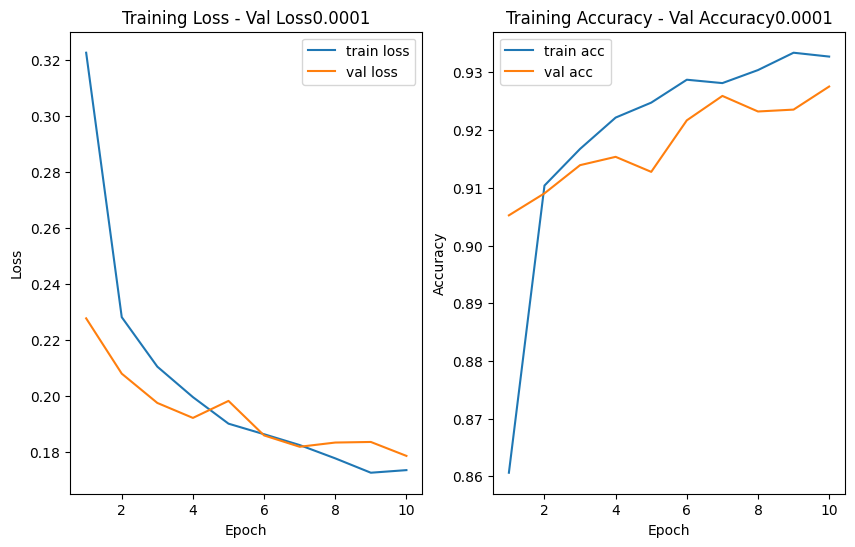

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(range(1,11), [epoch["loss"] for epoch in tuning_results[-1]["train_info"]], label="train loss")
plt.plot(range(1,11), [epoch["loss"] for epoch in tuning_results[-1]["val_info"]], label="val loss")
plt.legend()
plt.title("Training Loss - Val Loss"+ str(tuning_results[-1]["lr"]))
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2) # row 1, col 2 index 1
plt.plot(range(1,11), [epoch["acc"] for epoch in tuning_results[-1]["train_info"]], label="train acc")
plt.plot(range(1,11), [epoch["acc"] for epoch in tuning_results[-1]["val_info"]], label="val acc")
plt.legend()
plt.title("Training Accuracy - Val Accuracy"+ str(tuning_results[-1]["lr"]))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

### Final Model Training

In [ ]:
num_epochs = 7

lr = 1e-4 # choose a learning rate

# create a model and send it to cuda
model = VGG16_Updated(2) # binary classification
model = model.cuda()

# Create optimizer
opt = torch.optim.Adam(model.parameters(), lr=lr) # choose an optimizer

# You can use methods like early stopping based on validation loss to counter overfitting, reducing the learning rate on plateau etc.
# You can also plot the train, validation loss and accuracy curves

tuning = {"optimizer": "adam", "lr": lr, "train_info": [], "val_info": []}

for e in range(1, num_epochs+1):
    train_info = train_one_epoch(train_dataloader, opt)
    print("Training: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, train_info["loss"], 100*train_info["acc"], train_info["time"]))
    if e % eval_every == 0:
        val_info = test_val_one_epoch(val_dataloader)
        print("Validation: epoch: {}, loss: {:.2f}, accuracy: {:.2f} in {:.2f} seconds".format(e, val_info["loss"], 100*val_info["acc"], val_info["time"]))

        tuning["train_info"].append(train_info)
        tuning["val_info"].append(val_info)

tuning_results.append(tuning)

Training: epoch: 1, loss: 0.29, accuracy: 88.19 in 134.19 seconds
Validation: epoch: 1, loss: 0.23, accuracy: 90.21 in 10.02 seconds
Training: epoch: 2, loss: 0.22, accuracy: 91.60 in 132.79 seconds
Validation: epoch: 2, loss: 0.21, accuracy: 90.90 in 10.17 seconds
Training: epoch: 3, loss: 0.20, accuracy: 92.14 in 131.73 seconds
Validation: epoch: 3, loss: 0.20, accuracy: 91.50 in 9.96 seconds
Training: epoch: 4, loss: 0.20, accuracy: 92.40 in 130.58 seconds
Validation: epoch: 4, loss: 0.20, accuracy: 91.07 in 9.87 seconds
Training: epoch: 5, loss: 0.19, accuracy: 92.79 in 130.34 seconds
Validation: epoch: 5, loss: 0.19, accuracy: 91.93 in 9.89 seconds
Training: epoch: 6, loss: 0.18, accuracy: 92.89 in 130.36 seconds
Validation: epoch: 6, loss: 0.19, accuracy: 92.05 in 9.65 seconds
Training: epoch: 7, loss: 0.18, accuracy: 93.23 in 129.96 seconds
Validation: epoch: 7, loss: 0.19, accuracy: 92.19 in 9.18 seconds


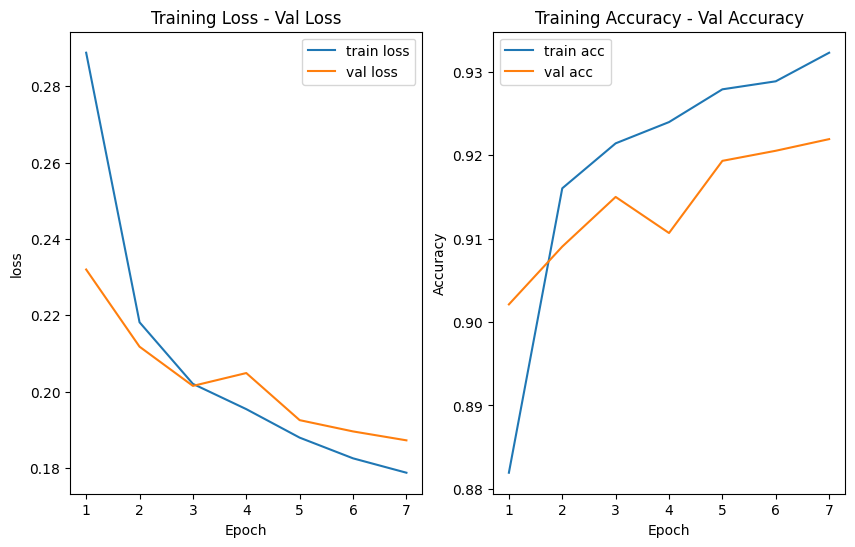

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(range(1,8), [epoch["loss"] for epoch in tuning_results[-1]["train_info"]], label="train loss")
plt.plot(range(1,8), [epoch["loss"] for epoch in tuning_results[-1]["val_info"]], label="val loss")
plt.legend()
plt.title("Training Loss - Val Loss")
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2) # row 1, col 2 index 1
plt.plot(range(1,8), [epoch["acc"] for epoch in tuning_results[-1]["train_info"]], label="train acc")
plt.plot(range(1,8), [epoch["acc"] for epoch in tuning_results[-1]["val_info"]], label="val acc")
plt.legend()
plt.title("Training Accuracy - Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

## 8) Test your classifier on Test set

- Apply same pre-processing as training data (Do not pre-process with data augmentation here, pre-processing refers to operations like resizing, normalization)
- Predict the labels of testing data **using the best model that you have selected according to your validation results** and report the accuracy.
- Construct a csv file with test predictions and submit it to SuCourse.

Please name the first column image_name and keep the name of the attributes as it is. (Do not change the order of the attributes). Name this file **submission.csv**

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Predict

model.eval()

y_pred = []
y_true = []
total = 0
acc = 0.0

with torch.no_grad():
    for data in tqdm(test_dataloader):
        inputs, labels = data["img"].cuda(), data["label"]
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1).cpu().tolist()
        y_pred.extend(preds)
        y_true.extend(labels)
        total += inputs.size(0)

# Report your result
print("\n")
print(f"Accuracy of the network on the {total} test images: {accuracy_score(y_true, y_pred)}")

100%|██████████| 24/24 [00:12<00:00,  1.98it/s]




Accuracy of the network on the 3000 test images: 0.9223333333333333


In [ ]:
submission = test_df.copy()
submission["y_pred"] = y_pred
submission.columns = ["image_name", "Male", "y_pred"]

In [ ]:
submission.head()

,image_name,Male,y_pred
6300,006301.jpg,0,0
23787,023788.jpg,0,0
20909,020910.jpg,0,0
9624,009625.jpg,1,1
19805,019806.jpg,1,1


In [ ]:
submission.to_csv("/content/drive/MyDrive/courses/spring2023/CS 515 - Deep Learning/HW-2/submission.csv")

### Introduction
* In this notebook, the aim was to gain experience with three-dimensional input data and understand the transfer
learning approach. A predetermined dataset that contains 30k celebrity images with face attributes and network
structure is provided, along with a starter notebook to help us with the assignment. From the facial attributes
given in the dataset, only "Male" (which represents gender) will be used as the target class, and binary classification
will be made.

### Approach & Experimental Setup
* The transfer learning method was preferred for the binary classification problem. In order to apply this method,
VGG-16 is taken as the base model. Instead of the classification head of the model, a problem-specific linear layer
has been added. Except for the classification layer, the other layers of the model (i.e. weights of the base model)
are frozen so that the training is carried out only for the classification layer.
* The data set used for the development of the model was divided into train-val-test dataset, respectively, at the
rates of 80%-10%-10%. The batch size was taken as 128 due to the size of the data set and the proper distribution of
data according to the classes. Hyperparameter tuning of the model was carried out by testing it on the validation
dataset. During the hyperparameter tuning, 3 parameters are based; optimizer, learning rate, and epoch.
* Initially, two different model structures created using SGD and Adam optimizer were trained and tested by setting
the learning rate parameter as 1e-5 and keeping the other parameters constant. As a result of the training held in
3 epochs, validation accuracy and training loss values were compared and it was decided to
continue with the Adam optimizer.
* After choosing the optimizer, 3 different learning rate values were selected to tune the learning rate value; 1e-3,
1e-4, and 1e-5. The training period was extended to 5 epochs compared to the previous stage so that the model
loss and accuracy curves could be observed more easily. First of all, the validation accuracy and training loss
curves of the trained models were compared. After this comparison, the 1e-5 value was
excluded from the comparison because the results were not good enough, and train-val loss curves were examined for the remaining values. As a result, the value of 1e-4 was chosen as the optimal value,
since a further decrease in the loss value was predicted.
* Finally, to determine the number of epochs, the model was trained for 10 epochs with the parameters determined
in the previous stages. As a result of the training, train-val accuracy and loss values were compared, especially since overfitting was observed after the 7th epoch in the loss graph, 7 epochs were determined
as the optimal value.
### Results
* As a result of the experiments, the Adam optimizer was used in the preferred model and the learning rate value
was chosen as 1e-4. The model was trained for 7 epochs and tested on a test set containing 3k data. The test
accuracy score was measured as 93%.




